# Figure 1: Exploratory data analysis

In [1]:
import pandas as pd
import numpy as np
from os import path
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA

## Load data

In [4]:
metadata_file = path.join('../..', 'data', 'processed', 'metadata.tsv')
logTPM_file = path.join('../..', 'data', 'processed','log_tpm.csv')
DF_metadata = pd.read_csv(metadata_file, sep='\t', index_col=0)
DF_log_tpm = pd.read_csv(logTPM_file,index_col=0)

In [5]:
FIGURE_DIR='../../figures'

## Panel b: Quality control pie chart

In [6]:
metadata_qc = path.join('../..', 'data','interim','metadata_qc_part2_all.tsv')
DF_metadata_qc = pd.read_csv(metadata_qc, sep='\t', index_col=0)

In [7]:
# Step 1: Check FastQC
failed_step1 = DF_metadata_qc[~DF_metadata_qc.passed_fastqc].index
df_passed_step1 = DF_metadata_qc[DF_metadata_qc.passed_fastqc]

# Step 2: Check number of reads mapped to CDS
failed_step2 = df_passed_step1[~df_passed_step1.passed_reads_mapped_to_CDS].index
df_passed_step2 = df_passed_step1[df_passed_step1.passed_reads_mapped_to_CDS]

# Step 3: Check global correlations
failed_step3 = df_passed_step2[~df_passed_step2.passed_global_correlation].index
df_passed_step3 = df_passed_step2[df_passed_step2.passed_global_correlation]

# Step 4: Check curation
failed_step4 = df_passed_step3[~df_passed_step3.passed_curation].index
df_passed_step4 = df_passed_step3[df_passed_step3.passed_curation]

# Step 5: Check replicate correlations
failed_step5 = df_passed_step4[~df_passed_step4.passed_replicate_correlations].index
df_passed_step5 = df_passed_step4[df_passed_step4.passed_replicate_correlations]

In [8]:
print('Total failed:',len(failed_step1) + len(failed_step2) + len(failed_step3) + len(failed_step4) + len(failed_step5))
print('Total passed:',len(DF_metadata))

Total failed: 26
Total passed: 142


In [9]:
values = [len(failed_step1),
          len(failed_step2),
          len(failed_step3),
          len(failed_step4),
          len(failed_step5),
          len(DF_metadata)]
labels = ['Failed FastQC','Too few reads mapped to CDS','Poor correlation with other datasets','Problems with metadata','Poor correlation between replicates','Passed']

In [10]:
len(DF_metadata_qc)

168

In [11]:
len(DF_metadata_qc) - np.cumsum(values)

array([168, 164, 164, 150, 142,   0])

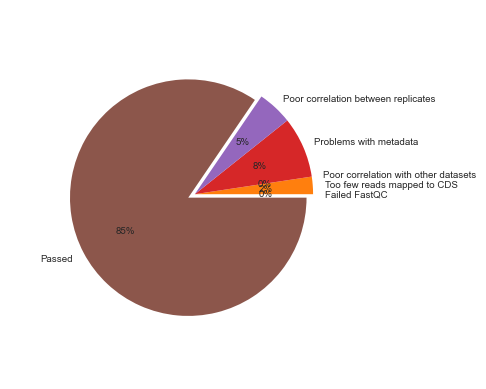

In [12]:
plt.pie(values,labels=labels,autopct = '%.0f%%',textprops={'fontsize':7},radius=0.8,wedgeprops={'linewidth':0},explode=[0,0,0,0,0,0.05]);
plt.savefig(path.join(FIGURE_DIR,'supp_QC_pie.pdf'))

## Panel c: Plot growth of dataset

In [17]:
DF_metadata_all = pd.read_csv('../../data/raw/metadata.csv')

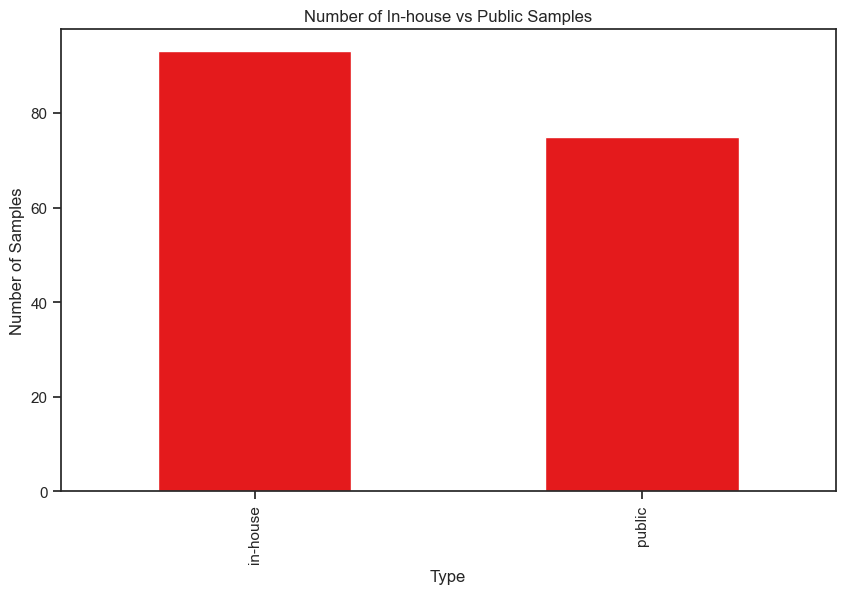

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set the Seaborn theme to 'white'
sns.set_theme(style='ticks', palette='Set1')

# Now you can group by 'Type' only
grouped = DF_metadata_all.groupby('type').size()

# Plot the result as a bar graph
grouped.plot(kind='bar', figsize=(10, 6))
plt.xlabel('Type')
plt.ylabel('Number of Samples')
plt.title('Number of In-house vs Public Samples')
plt.savefig('../../figures/dataset_comparison.svg')
plt.show()

## Panel d: Principal component analysis

First compute principal components.

In [19]:
pca = PCA()
DF_weights = pd.DataFrame(pca.fit_transform(DF_log_tpm.T),index=DF_log_tpm.columns)
DF_components = pd.DataFrame(pca.components_.T,index=DF_log_tpm.index)

Next, plot the cumulative explained variance

Number of dimensions for 95% of variance: 36


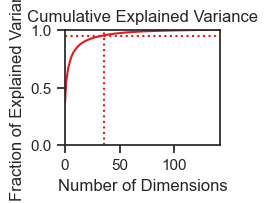

In [20]:
# Set the explained variance threshold
var_cutoff = 0.95

fig,ax = plt.subplots(figsize=(2,1.5))
pca_var = np.cumsum(pca.explained_variance_ratio_)
ax.plot(pca_var)
dims = np.where(pca_var > var_cutoff)[0][0] + 1
ax.vlines(dims,0,1,linestyles='dotted')
ax.hlines(var_cutoff,0,len(DF_log_tpm.columns),linestyles='dotted')
ax.set_ylim(0,1)
ax.set_xlim(0,len(DF_log_tpm.columns))
ax.set_ylabel('Fraction of Explained Variance')
ax.set_xlabel('Number of Dimensions')
ax.set_title('Cumulative Explained Variance')
print('Number of dimensions for 95% of variance:',dims)
# plt.savefig(path.join(FIGURE_DIR,'Fig1_.pdf'))

Finally, plot the first two principle components. The following code colors data by the ``project``. To color by other attributes, change the ``attribute`` variable.

This function requires a few global variables (i.e. ``DF_metadata``, ``DF_weights``, etc.)

In [21]:
sns.set_theme(style='white', palette='Set1')
def plot_pca(attribute):
    fig,ax = plt.subplots(figsize=(5,5))
    df_metadata_tmp = DF_metadata.copy()
    df_metadata_tmp.fillna('Not reported',inplace=True)
    for name,group in df_metadata_tmp.groupby(attribute):
        ax.scatter(DF_weights.loc[group.index,0],
                   DF_weights.loc[group.index,1],
                   label=name,alpha=0.8)

    ax.set_xlabel('Principal Component 1: %.0f%%'%(pca.explained_variance_ratio_[0]*100))
    ax.set_ylabel('Principal Component 2: %.0f%%'%(pca.explained_variance_ratio_[1]*100))

    ax.set_title('Principal Component Plot')
    plt.legend(bbox_to_anchor=(1,1),ncol=2)

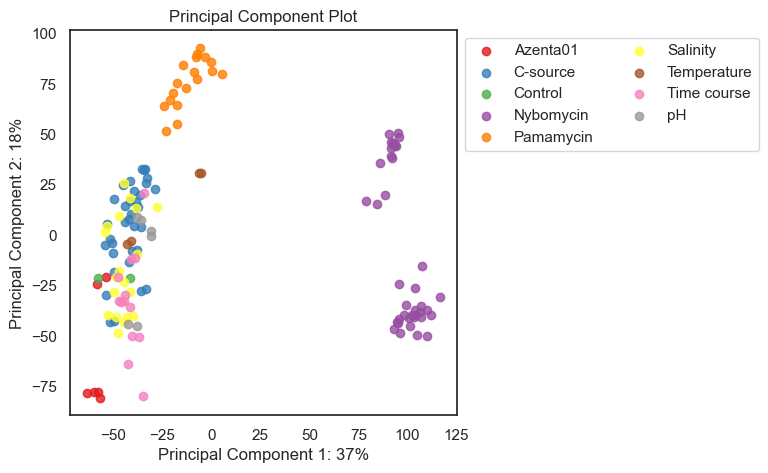

In [22]:
plot_pca('project')

Growth phase seems to explain to the greatest variation in expression, with exponential growth on the left and biofilm/sporulation to the right.

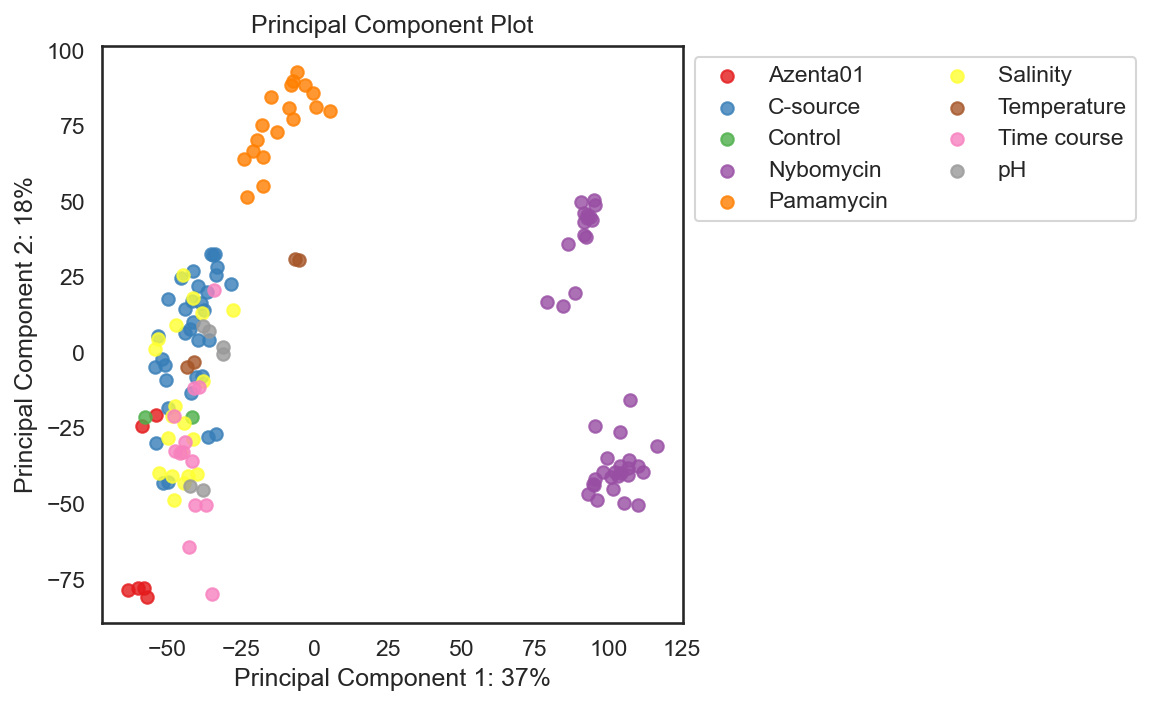

In [20]:
plot_pca('project')
plt.savefig(path.join(FIGURE_DIR,'PCA_project.svg'))

In [12]:
# Top left outliers
outliers = DF_weights[1].sort_values().tail(6)
outliers.sort_index()

SRX10298353    84.560350
SRX10298364    88.528716
SRX10298365    85.931272
SRX10298367    89.886651
SRX10298368    93.015799
SRX10298369    88.538469
Name: 1, dtype: float64

## Panel e: Expression bar chart

In [23]:
from pymodulon.plotting import *
from pymodulon.io import *

In [24]:
data_file = path.join('../..','data','processed','salb.json.gz')
ica_data = load_json_model(data_file)

In [25]:
import pandas as pd

rec_var = {}
for k in ica_data.imodulon_names:
    rec_var[k] = explained_variance(ica_data,imodulons=k)
df_rec_var = pd.Series(rec_var)
df_rec_var = df_rec_var.sort_values(ascending=False)
df_rec_var.head(10)

Chaplin                 0.157482
UC-1                    0.089940
BGC-General             0.052964
UC-13                   0.036333
Candicidin/Antimycin    0.030164
Surugamide-1            0.025221
Translation             0.024110
Phosphate               0.023105
SGR PTM                 0.020946
RpoS                    0.019444
dtype: float64

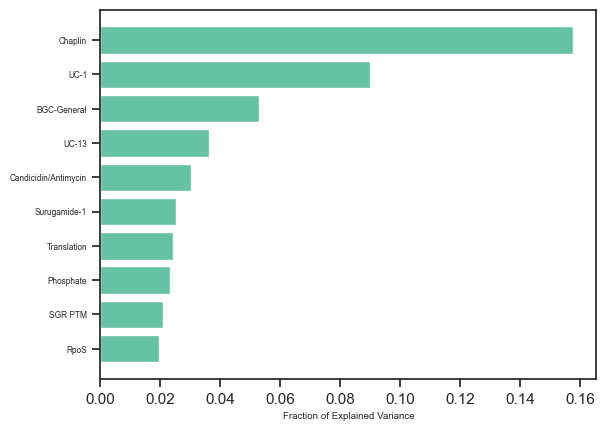

In [26]:
sns.set_theme(style='ticks', palette='Set2')
plt.barh(range(10,0,-1),df_rec_var.head(10),tick_label = df_rec_var.head(10).index)
plt.xlabel('Fraction of Explained Variance',fontsize=7)
# Rename uncharacterized-5 to ppGpp
new_labels = [x if x != 'uncharacterized-5' else 'ppGpp' for x in df_rec_var.head(10).index]
plt.yticks(range(10,0,-1),labels=new_labels,fontsize=6)
plt.savefig(path.join(FIGURE_DIR,'Fig1e_top10_imods.svg'))

In [28]:
print('Number of iModulons:',len(ica_data.imodulon_names))
print('Percent variance explained: {:.0f}%'.format(explained_variance(ica_data)*100))

Number of iModulons: 63
Percent variance explained: 80%


## venn diagram imodulon functions

In [105]:
ica_data.imodulon_table['function'] = ica_data.imodulon_table['function'].replace('Unknown', 'Uncharacterized')
ica_data.imodulon_table

,imodulon_size,explained_variance,function
Fatty Acid,97,0.006052,Fatty Acid Metabolism
Nucleoside,24,0.003215,Carbon Metabolism
Cytochrome,16,0.004825,Energy production and Conversion
Transketolase,21,0.010579,Amino Acid Metabolism
Cyclofaulknamycin-2,17,0.002131,Secondary Metabolism
...,...,...,...
UC-13,93,0.036333,Uncharacterized
SAL-2242,42,0.004464,Secondary Metabolism
UC-14,127,0.002833,Uncharacterized
Sugar-2,6,0.000503,Carbon Metabolism


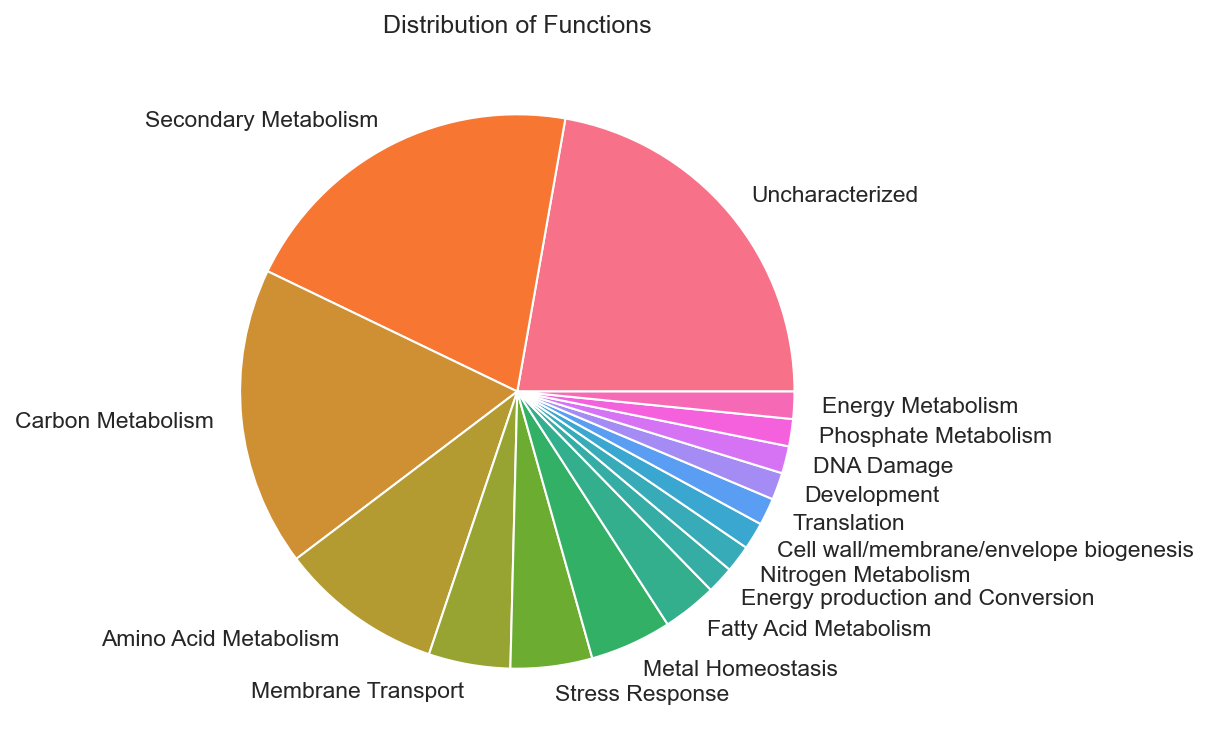

In [131]:
# Generate a 'husl' palette with 16 colors
palette = sns.color_palette('husl', 16)

# Set the current palette to the generated palette
sns.set_palette(palette)

# Count the number of occurrences of each function
function_counts = ica_data.imodulon_table['function'].value_counts()

# Plot the counts as a pie chart without percentages
function_counts.plot.pie(figsize=(10, 6))

function_counts.to_csv(path.join(FIGURE_DIR,'function_counts.csv'))

# Remove the 'function' label on the y-axis
plt.ylabel('')

plt.title('Distribution of Functions')
plt.savefig(path.join(FIGURE_DIR,'function_pie.svg'))
plt.show()

In [27]:
data_for_treemap = ica_data.imodulon_table[['function','imodulon_size']].reset_index()
data_for_treemap.columns = ['iModulon','function','size']
data_for_treemap

data_for_treemap.to_csv(path.join('../..','data','interim','data_for_treemap.csv'))